# T5 Model FineTuning #

T5 model is a pre-trained deep learning model that is based on the transformer-architecture. The T5's primary focus of application is in the field of Text-To-Text transformations i.e. Question-Answering, Translation, and Summarization.

Our main task in this notebook will be to create a fine-tuned model that will take in an abstract from a research article, and generate a title based on the input information.

**Dataset**

The dataset is provide in the repo is from kaggle. You can find this on kaggle from this link: https://www.kaggle.com/vetrirah/janatahack-independence-day-2020-ml-hackathon?select=train.csv


*Quoted from the kaggle description*:

**Topic Modeling for Research Articles
Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Tagging or topic modelling provides a way to give token of identification to research articles which facilitates recommendation and search process. Given the abstract and title for a set of research articles, predict the topics for each article included in the test set.**

Even though the purpose of the dataset is to predict the topics of the articles, we will only be using it for the primary purpose of fine-tuning our pretrained T5 model to generate a title for each input abstract text.

In [1]:
!pip install transformers

In [2]:
train_data_loc = "/content/train.csv"
test_data_loc = "/content/test.csv"

In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration
from torch.utils.data import random_split, RandomSampler
from nltk.translate.bleu_score import sentence_bleu
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch

**Hardware accelerator**

I will highly recommend you to use Hardware accelerator instead of using the default CPU the colab provides. If you have access to an A100 or V100 GPU, they will offer the best performance for fine-tunning large models like T5. If you're on a budget or have a more modest-sized model, the T4 GPU can be a reasonable choice. Another option is TPU, they can provide excellent performance for certain models and tasks. However, support for TPUs can be limited compared to GPUs. Not all libraries and models are fully compatible with TPUs. If you are using TPU then you may need to adjust your code and configuration.

If you have changed the runtime and have enablesd the hardware accelerator then there is a chance the the runtime enviroment would be reset, then re-run all of the cells above.

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
train_df = pd.read_csv(train_data_loc, encoding='utf-8')
test_df = pd.read_csv(test_data_loc, encoding='utf-8')

In [6]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [7]:
test_df.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [8]:
# Here we drop the columns that don't pertain to our task at hand

train_df.drop(columns=['ID','Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'], inplace=True)

test_df.drop(columns=['ID'], inplace=True)

The first thing I wanted to do was some exploratory data analysis. Primarily finding the distribution of word counts in all of our samples. The reason I do this is that due to memory constraints, the GPU may run out of memory.

In [9]:
# Descr: To display plots and metrics regarding token quantity in given input text
# Arguements:
# =====================================================================
# arr1 - input array 1
# arr2 - input array 2
# show_distr - whether to show plots of distributions
# return_distr - whether to return distribution arrays
# =====================================================================

def DisplayMaxTokens(arr1, arr2, show_distr = False, return_distr = False):
    arr1_maxlen = 0
    arr2_maxlen = 0

    seq1_LenArr = []
    seq2_LenArr = []

    for seq1, seq2 in zip(arr1, arr2):
        seq1_text = len(str(seq1).split())
        seq2_text = len(str(seq2).split())

        seq1_LenArr.append(seq1_text)
        seq2_LenArr.append(seq2_text)

        if(seq1_text > arr1_maxlen):
            arr1_maxlen = seq1_text
        if(seq2_text > arr2_maxlen):
            arr2_maxlen = seq2_text

    print("Maximum number of tokens in Array1: ", arr1_maxlen)
    print("Maximum number of tokens in Array2: ", arr2_maxlen)

    if(show_distr == True):
        sns.displot(seq1_LenArr);
        sns.displot(seq2_LenArr);

    if(return_distr == True):
        return seq1_LenArr, seq2_LenArr

Maximum number of tokens in Array1:  40
Maximum number of tokens in Array2:  200


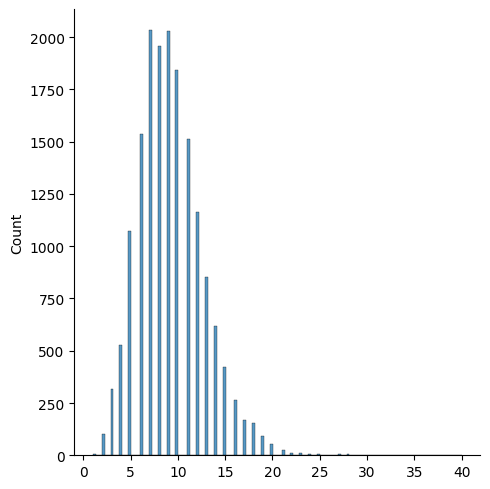

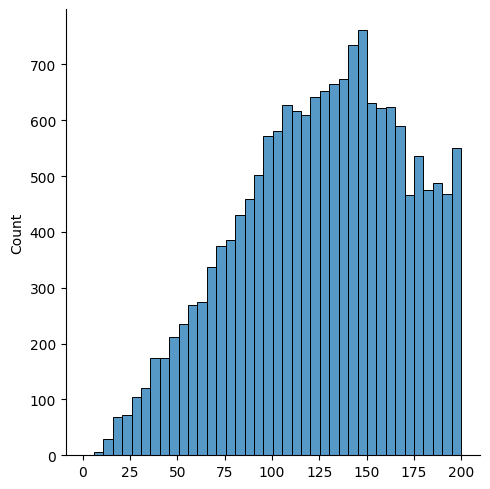

In [28]:
title_arr = train_df['TITLE']
abstract_arr = train_df['ABSTRACT']

textlen_Arr, abstractlen_Arr = DisplayMaxTokens(title_arr, abstract_arr, show_distr=True, return_distr = True)

On seeing the above distributions we can see how our word count distribution is. I split the dataset such that we only consider the samples where the abstract is less than 200 words. Based on this we split both the training observations and the test observations.

In [11]:
train_df['abs_len'] = abstractlen_Arr

train_df = train_df[train_df['abs_len'] <= 200]

In [12]:
title_arr = test_df['TITLE']
abstract_arr = test_df['ABSTRACT']

textlen_Arr, abstractlen_Arr = DisplayMaxTokens(title_arr, abstract_arr, show_distr=False, return_distr = True)
test_df['abs_len'] = abstractlen_Arr

test_df = test_df[test_df['abs_len'] <= 200]

Maximum number of tokens in Array1:  38
Maximum number of tokens in Array2:  391


In [13]:
train_df.reset_index()
train_df.head()

,TITLE,ABSTRACT,abs_len
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,76
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,99
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,110
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,125
6,On the rotation period and shape of the hyperb...,We observed the newly discovered hyperbolic ...,105


In [14]:
test_df.reset_index()
test_df.head()

,TITLE,ABSTRACT,abs_len
0,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,96
1,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,135
2,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,126
4,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,119
5,Pairwise Difference Estimation of High Dimensi...,This paper proposes a regularized pairwise d...,101


In [15]:
title_arr = train_df['TITLE']
abstract_arr = train_df['ABSTRACT']

title_arr = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,\n]", '', title) for title in title_arr]
abstract_arr = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,\n]", '', abstract) for abstract in abstract_arr]

Here we declare our ResearchDataset Class which is inherited from Pytorch's DataSet class. An effective way of preparing and loading data.

In [16]:
# Descr: Dataset class which is used to load our training data
# Constructor Arguements:
# =====================================================================
# title_arr - Array of article titles
# abstract_arr - Array of article abstracts
# tokenizer - Input tokenizer used to tokenize our text
# =====================================================================

class ResearchDataset(Dataset):
    def __init__(self, title_arr, abstract_arr, tokenizer):
        self.title_arr = title_arr
        self.abstract_arr = abstract_arr
        self.tokenizer = tokenizer

        def ArrayLength():
            title_arr_length = len(self.title_arr)
            if(title_arr_length == len(self.abstract_arr)):
                return title_arr_length
            else:
                raise Exception("Array Lengths not Equal!!!")

        self.arr_len = ArrayLength()

    def __len__(self):
        return self.arr_len

    def __getitem__(self, index):
        title = self.title_arr[index]
        abstract = self.abstract_arr[index]

        input_ = abstract + " </s>"
        output_ = title + " </s>"

        #Encoding our inputs
        inputs = self.tokenizer.encode_plus(input_, pad_to_max_length=True,return_attention_mask=True, max_length=201)
        #Encoding our outputs
        outputs = self.tokenizer.encode_plus(output_, pad_to_max_length=True,return_attention_mask=True, max_length=41)

        input_ids = inputs['input_ids']
        input_attention_masks = inputs['attention_mask']

        output_ids = outputs['input_ids']
        output_attention_masks = outputs['attention_mask']

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'input_mask': torch.tensor(input_attention_masks, dtype=torch.long),
            'output_ids': torch.tensor(output_ids, dtype=torch.long),
            'output_mask': torch.tensor(output_attention_masks, dtype=torch.long)
        }

**SentencePiece Error**

If the cell below throw an exception of SentencePiece then run this cell to install its latest version. It happens usually. After installing SentencePiece, restart your runtime and you are good to go!

In [17]:
!pip install SentencePiece

In [18]:
# Loading pre-trained T5-base Tokenizer of T5-base Model

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.to(device);

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:238: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

In [19]:
# Performing splitting of our Dataset in train and validation. Because we were already provided a Validation Dataset, we will not be splitting our train set here, hence our trainset_ratio = 1.0

research_dataset = ResearchDataset(title_arr, abstract_arr,tokenizer)

trainset_ratio = 1.0

data_len = len(research_dataset)
print("Total Data Size: ", data_len)

training_data_size = int(data_len*trainset_ratio)
print("Training Data Size: ", training_data_size)

val_data_size = data_len - training_data_size
print("Validation Data Size: ", val_data_size)

train_dataset, validation_dataset = random_split(research_dataset, [training_data_size, val_data_size])

batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size=batch_size)

if(trainset_ratio != 1.0):
    validation_dataloader = DataLoader(validation_dataset, sampler = RandomSampler(validation_dataset), batch_size=batch_size)

Total Data Size:  16807
Training Data Size:  16807
Validation Data Size:  0


In [20]:
# Our actual Process of fine-tuning is done here

LEARNING_RATE = 1e-05

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

epochs = 1
steps2report = 500

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

for epoch in range(0,epochs):
    model.train()
    for step, data in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Getting input parameters
        x_input_ids = data['input_ids'].to(device)
        x_masks = data['input_mask'].to(device)

        # Getting output parameters
        y_expl_ids = data['output_ids'].to(device)

        # Feeding values into our model
        outputs = model(input_ids              = x_input_ids,
                        attention_mask         = x_masks,
                        labels                 = y_expl_ids)
        loss = outputs[0]

        if step%steps2report==0:
            print("EPOCH: ", epoch, " loss.item: ", loss.item())

        loss.backward()
        optimizer.step()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:301: UserWarning:

EPOCH:  0  loss.item:  10.752716064453125
EPOCH:  0  loss.item:  1.5570911169052124
EPOCH:  0  loss.item:  1.0356229543685913


## **Download the model Locally**

If you want to download the model locally on your machine then run the 5 cells below, these cells will let you to download the exported folder's zipfile locally on your machine and also let you to save the zipfile on your google drive accout.

In [31]:
model_repository = "/content/"
model_name = "FineTuned_T5_Title_Abstract"

model.save_pretrained(model_repository+model_name)

In [32]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained("../trained_models/FineTuned_T5_Title_Abstract");
model.to(device);

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:238: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Run the cell below to create a zip file of the exported folder

In [37]:
import zipfile
import os

folder_path = "/content/FineTuned_T5_Title_Abstract"
output_zip_path = "/content/Abstract2Title_T5_model"

if os.path.exists(output_zip_path):
    raise FileExistsError("The specified output path already exists as a directory. Please provide a output path for the zip file.")
else:
    # Create a zip file
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))


Run the cell below to mount your drive account **if you have not mounted**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

This cell moves the resulting zip file to your Google Drive. You can access it in Google Drive and download it to your local machine from there as well.

In [39]:
import shutil

shutil.move("/content/Abstract2Title_T5_model.zip", "/content/drive/MyDrive/Colab Notebooks/Abstract2Title_T5_model.zip")

FileNotFoundError: ignored

### Validation ###

Now that the process of fine-tuning is over, we can now get to the process of validation. We start out by pre-processing our test dataframes and creating our Test-ResearchDataSet and Test-DataLoader. After this we then go through our validation loop where we generate a prediction from each input_id and input_mask, we then store that prediction in model_outputArr, and the expected predictions in target_outputArr.

In [23]:
title_arr = test_df['TITLE']
abstract_arr = test_df['ABSTRACT']

title_arr = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,\n]", '', title) for title in title_arr]
abstract_arr = [re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,\n]", '', abstract) for abstract in abstract_arr]

batch_size = 32
testresearch_dataset = ResearchDataset(title_arr, abstract_arr, tokenizer)
test_dataloader = DataLoader(testresearch_dataset, sampler = RandomSampler(testresearch_dataset), batch_size=batch_size)

In [24]:
import torch
model.eval()

model_inputArr = []
model_outputArr = []
target_outputArr = []

with torch.no_grad():
    for step, data in enumerate(test_dataloader):
        input_ids = data["input_ids"].to(device)
        input_masks = data["input_mask"].to(device)
        explanation_ids = data["output_ids"].to(device)
        explanation_masks = data["output_mask"].to(device)
        output = model.generate(input_ids = input_ids, attention_mask = input_masks, max_length=200,do_sample=False )

        for input_vector, output_vector in zip(input_ids, output):
            model_inputArr.append(tokenizer.decode(input_vector, skip_special_tokens=True))
            model_outputArr.append(tokenizer.decode(output_vector, skip_special_tokens=True))
        target_outputArr.append(tokenizer.batch_decode(explanation_ids, skip_special_tokens=True))

target_outputArr = [item for sublist in target_outputArr for item in sublist]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:301: UserWarning:

In [25]:
# Creating a new dataframe that contains our input, model predicted outout, and expected target output

data_ = {
    'input' : model_inputArr,
    'model output' : model_outputArr,
    'target output' : target_outputArr
}
results_dataframe = pd.DataFrame(data = data_)

In [26]:
results_dataframe.head()

,input,model output,target output
0,In this paper the possibility to bring about t...,Double valley Diracfermions in 3D TI,Double valley Dirac fermions for 3D and 2D Hg$...
1,Since more than twenty years Internet evolves ...,Regional InterneteXchange Points in the Indian...,Poor Peering a reflexion about a RIXP
2,We theoretically demonstrate a strong dependen...,Molecular annihilation of singlet excitons,ExcitonExciton Annihilation Is Coherently Supp...
3,Let $n geq 4$ and let $Omega$ be a bounded hyp...,holomorphic function on a connected hyperconve...,The extension of holomorphic functions on a no...
4,We study the problem of controlling linear tim...,Online Learning for Time-Invariant Systems wit...,Online Linear Quadratic Control


### BLEU Evaluation ###

Now that we have our predictions, we can evaluate the quality of our predictions based on the Bi-Lingual Evaluation Understudy(BLEU). In brief, we compare our generated sentences with our target sentences by counting the matching n-grams. In layman's terms, how well individual segment texts match from our predicted text to the expected text.

In [27]:
bleu_scores = []

for model_output, target_output in zip(model_outputArr, target_outputArr):
    model_token_arr = model_output.split();
    target_token_arr = model_output.split();

    score = sentence_bleu([target_token_arr], model_token_arr)

    bleu_scores.append(score)

print("Average Bleu Score: ", np.mean(bleu_scores))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average Bleu Score:  0.9584905660377359
